In [1]:
import random
import string
import torch
import time
import numpy as np
import networkx as nx
import logging
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import numpy as np
import torch



/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(14)

# Set up logging to only show INFO level messages and higher
logging.basicConfig(level=logging.INFO, # Set to INFO
                    format='%(asctime)s - %(levelname)s - %(message)s')

def generate_name() -> str:
    # Changed to k=4 for better tokenization robustness as discussed
    name = ''.join(random.choices(string.ascii_lowercase, k=2)) 
    # logging.debug(f"Generated node name: {name}") # Suppress debug for INFO level
    return name

def get_grid_graph_3x3(nodes=None):
    if nodes is None:
        nodes = [generate_name() for _ in range(9)]
    logging.info(f"Building 3x3 grid graph with nodes: {nodes}")
    G = nx.DiGraph()

    east_pairs = [(nodes[0], nodes[1]), (nodes[1], nodes[2]),
                  (nodes[3], nodes[4]), (nodes[4], nodes[5]),
                  (nodes[6], nodes[7]), (nodes[7], nodes[8])]
    south_pairs = [(nodes[0], nodes[3]), (nodes[3], nodes[6]),
                   (nodes[1], nodes[4]), (nodes[4], nodes[7]),
                   (nodes[2], nodes[5]), (nodes[5], nodes[8])]
    west_pairs  = [(v, u) for (u, v) in east_pairs]
    north_pairs = [(v, u) for (u, v) in south_pairs]

    for n in nodes:
        G.add_node(n)
    for (u, v) in east_pairs:
        G.add_edge(u, v, direction='R')
    for (u, v) in west_pairs:
        G.add_edge(u, v, direction='L')
    for (u, v) in south_pairs:
        G.add_edge(u, v, direction='D')
    for (u, v) in north_pairs:
        G.add_edge(u, v, direction='U')

    logging.debug("Graph construction complete.") # This will not show with INFO level
    return G

In [3]:
model_paths = {
    "gpt2-base": "gpt2",
    "checkpoint-mid": "spatial_model/checkpoint-22355",
    "checkpoint-final": "spatial_model/checkpoint-44659"
}

In [4]:

def generate_long_random_walk(G, walk_length=50):
    nodes = list(G.nodes)
    current_node = random.choice(nodes)
    walk = [current_node]
    logging.debug(f"Starting random walk at node: {current_node}")
    while len(walk) < walk_length:
        neighbors = list(G.successors(current_node))
        if not neighbors:
            logging.debug("No neighbors found; terminating walk early.")
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    logging.info(f"Generated random walk of length {len(walk)}")
    return walk

def walk_to_string(walk, G):
    tokens = []
    for i in range(len(walk) - 1):
        node1 = walk[i]
        node2 = walk[i+1]
        direc = G.edges[(node1, node2)]['direction']
        tokens.append(node1)
        tokens.append(direc)
    tokens.append(walk[-1])
    prompt = " ".join(tokens)
    logging.debug(f"Converted walk to prompt: {prompt[:100]}...")
    return prompt

class GPTWrapper:
    def __init__(self, model_name='gpt2'):
        logging.info(f"Loading model: {model_name}")
        path = model_paths.get(model_name, model_name)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        #self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        logging.info("Model and tokenizer loaded successfully.")

    def get_hidden_states_with_offsets(self, prompt, layer_idx):
        logging.info("Tokenizing prompt and obtaining offsets.")
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             truncation=True,
                             return_offsets_mapping=True)
        logging.debug(f"Tokenization complete. Number of tokens: {len(enc['input_ids'][0])}")
        out = self.model(**enc)
        hidden_states = out.hidden_states[layer_idx].squeeze(0).detach().numpy()
        offsets = enc["offset_mapping"][0].tolist()
        input_ids = enc["input_ids"]
        logging.info("Obtained hidden states and offsets from model.")
        return hidden_states, offsets, input_ids

def substring_positions(haystack, needle):
    result = []
    start = 0
    logging.debug(f"Searching for substring '{needle}' in the prompt.")
    while True:
        idx = haystack.find(needle, start)
        if idx == -1:
            break
        result.append([idx, idx + len(needle)])
        logging.debug(f"Found '{needle}' at position: {result[-1]}")
        start = idx + 1
    if not result:
        logging.debug(f"No occurrences of '{needle}' found.")
    return result

def gather_embeddings_for_span(offsets, hidden_states, span):
    (start_needed, end_needed) = span
    overlap_vecs = []
    logging.debug(f"Gathering embeddings for span: {span}")
    for i, (start_off, end_off) in enumerate(offsets):
        # Check if token span overlaps with the desired span
        if not (end_off <= start_needed or start_off >= end_needed):
            overlap_vecs.append(hidden_states[i])
    if not overlap_vecs:
        logging.debug("No overlapping tokens found for span.")
        return None
    averaged = np.mean(overlap_vecs, axis=0)
    logging.debug("Averaged embedding computed for span.")
    return averaged

def average_locations_via_substring(prompt, offsets, hidden_states, locs):
    loc_means = {}
    logging.info("Averaging embeddings for each location.")
    for loc in locs:
        pos_list = substring_positions(prompt, loc)
        if not pos_list:
            logging.warning(f"Location '{loc}' not found in prompt.")
            continue
        found_vecs = []
        for (s, e) in pos_list:
            emb = gather_embeddings_for_span(offsets, hidden_states, (s, e))
            if emb is not None:
                found_vecs.append(emb)
        if found_vecs:
            loc_means[loc] = np.mean(found_vecs, axis=0)
            logging.debug(f"Averaged embedding for location '{loc}' computed.")
        else:
            logging.warning(f"No embeddings found for location '{loc}'.")
    return loc_means

def build_positions_3x3(node_names):
    node_positions = {}
    idx = 0
    for r in range(3):
        for c in range(3):
            node_positions[node_names[idx]] = (r, c)
            idx += 1
    logging.debug(f"Node positions on grid: {node_positions}")
    return node_positions

def calc_pearson_correlation(node_names, loc_mean_repr):
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 2:
        logging.warning("Not enough recognized nodes to compute Pearson correlation.")
        return float('nan')

    man_distances = []
    rep_distances = []
    positions = build_positions_3x3(node_names)

    for i in range(len(recognized)):
        for j in range(i+1, len(recognized)):
            u = recognized[i]
            v = recognized[j]
            (r1, c1) = positions[u]
            (r2, c2) = positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
            man_distances.append(man_dist)
            rep_distances.append(rep_dist)

    if len(man_distances) < 2:
        logging.warning("Insufficient distance pairs for correlation.")
        return float('nan')

    r, _ = pearsonr(man_distances, rep_distances)
    logging.info(f"Pearson correlation computed: {r:.3f}")
    return r



In [13]:
model_colors = {
    "gpt2-base": plt.get_cmap("tab10")(0),     # First color from tab10 
    "checkpoint-mid": plt.get_cmap("tab10")(1),
    "checkpoint-final": plt.get_cmap("tab10")(2)} 

In [19]:
def plot_all_runs_in_one_pca(all_points, all_edges, model_name, reducer="pca"):
    if not all_points:
        logging.error("No data to plot.")
        return

    # Build array for dimensionality reduction.
    X = np.array([pt['vector'] for pt in all_points])
    X_centered = X - X.mean(axis=0, keepdims=True)

    if reducer.lower() == "pca":
        dim_red = PCA(n_components=2)
    else:
        dim_red = UMAP(n_components=2)
    X_2d = dim_red.fit_transform(X_centered)

    for i, coords in enumerate(X_2d):
        all_points[i]['x2d'] = coords[0]
        all_points[i]['y2d'] = coords[1]

    # Color-code points by their grid position.
    grid_positions = sorted(set(pt['grid_position'] for pt in all_points))
    cmap = plt.get_cmap("tab10")  # 10 distinct colors, good for up to 9 positions.
    plt.figure(figsize=(3,3))
    for i, pos in enumerate(grid_positions):
        pos_points = [p for p in all_points if p['grid_position'] == pos]
        xs = [p['x2d'] for p in pos_points]
        ys = [p['y2d'] for p in pos_points]
        color = cmap(i % 10)
        plt.scatter(xs, ys, color=color, label=f"{pos}")
    
    # Color edges based on the grid position of the source node.
    for e in all_edges:
        i_idx = e['u_index']
        j_idx = e['v_index']
        x1, y1 = all_points[i_idx]['x2d'], all_points[i_idx]['y2d']
        x2, y2 = all_points[j_idx]['x2d'], all_points[j_idx]['y2d']
        pos = all_points[i_idx]['grid_position']
        pos_index = grid_positions.index(pos)
        color = cmap(pos_index % 10)
        plt.plot([x1, x2], [y1, y2], '--', color=color, alpha=0.0)

    #plt.grid(True)
    if model_name == 'gpt2-small':
        plt.legend()
    plt.savefig(f'{model_name}_combined_{reducer}.png', dpi=200, bbox_inches='tight')
    logging.info(f"Saved combined plot as {model_name}_combined_{reducer}.png")

def boxplot_of_dist_map(global_dist_map, model_name):
    if not global_dist_map:
        logging.error("No distance data to plot boxplot.")
        return
    sorted_keys = sorted(global_dist_map.keys())
    data_for_box = [global_dist_map[k] for k in sorted_keys]
    plt.figure(figsize=(3, 2))
    plt.boxplot(data_for_box, showfliers=False, showmeans=False)
    plt.xticks(range(1, len(sorted_keys)+1), sorted_keys)
    plt.xlabel("Distance in grid")
    plt.ylabel("Distance between rep.s")
    #plt.grid(True, axis='y', alpha=0.5)
    plt.savefig(f'{model_name}_boxplot.png', dpi=200, bbox_inches='tight')
    logging.info(f"Saved boxplot as {model_name}_boxplot.png")

def merge_dist_map(global_dist_map, dist_map):
    for manD, repList in dist_map.items():
        global_dist_map.setdefault(manD, []).extend(repList)
    logging.debug("Merged distance map for current run.")

def gather_boxplot_data(node_names, loc_mean_repr):
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 2:
        logging.warning("Not enough recognized nodes for boxplot data.")
        return {}
    node_positions = build_positions_3x3(node_names)
    dist_map = {}
    for i in range(len(recognized)):
        for j in range(i+1, len(recognized)):
            u = recognized[i]
            v = recognized[j]
            (r1, c1) = node_positions[u]
            (r2, c2) = node_positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            if man_dist > 0:
                rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
                dist_map.setdefault(man_dist, []).append(rep_dist)
    logging.debug("Boxplot data gathered for current run.")
    return dist_map
    
def multi_graph_allinone(
    model_name="gpt2",
    layer_idx=10,
    n_runs=10,
    walk_length=2000,
    reducer="pca"
):
    logging.info("Starting multi_graph_allinone analysis.")
    all_points = []
    all_edges = []
    global_dist_map = {}
    point_index = 0
    wrapper = GPTWrapper(model_name) # moved outside the loop to avoid reloading the model each run

    for run_idx in range(n_runs):
        logging.info(f"\n=== RUN {run_idx+1}/{n_runs} ===")
        node_names = [generate_name() for _ in range(9)]
        G = get_grid_graph_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length)
        prompt = walk_to_string(walk, G)
        logging.debug(f"Run {run_idx+1}: Nodes: {node_names}")
        logging.debug(f"Run {run_idx+1}: Prompt snippet: {prompt[:200]}...")

        #wrapper = GPTWrapper(model_name)
        hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)

        # Get grid positions (e.g., (0,0) for NW corner, etc.)
        grid_positions_mapping = build_positions_3x3(node_names)

        node_to_point_idx = {}
        recognized_nodes = [n for n in node_names if n in loc_mean_repr]
        for n in recognized_nodes:
            vec = loc_mean_repr[n]
            d = {
                'run_idx': run_idx,
                'node_name': n,
                'vector': vec,
                'grid_position': grid_positions_mapping[n]  # store grid pos
            }
            all_points.append(d)
            node_to_point_idx[n] = point_index
            point_index += 1

        for (u, v) in G.edges():
            if u in node_to_point_idx and v in node_to_point_idx:
                all_edges.append({
                    'run_idx': run_idx,
                    'u_name': u,
                    'v_name': v,
                    'u_index': node_to_point_idx[u],
                    'v_index': node_to_point_idx[v]
                })

        dist_map = gather_boxplot_data(node_names, loc_mean_repr)
        merge_dist_map(global_dist_map, dist_map)
        logging.info(f"Run {run_idx+1} complete.")

    plot_all_runs_in_one_pca(all_points, all_edges, model_name, reducer=reducer)
    boxplot_of_dist_map(global_dist_map, model_name)
    logging.info("multi_graph_allinone analysis completed.")

def rolling_mean(values, window=3):
    out = []
    for i in range(len(values)):
        start = max(0, i - window + 1)
        subset = values[start:i+1]
        out.append(np.mean(subset))
    logging.debug("Computed rolling mean for correlations.")
    return out

def correlation_vs_context_length(
    model_name="gpt2",
    layer_idx=12,
    context_lengths=None,
    n_runs=100,
    rolling_window=1
):
    """
    Single-model version. Produces a single line on a single plot.
    """
    if context_lengths is None:
        context_lengths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

    avg_correlations = []
    logging.info("Starting correlation_vs_context_length analysis.")
    wrapper = GPTWrapper(model_name) # moved outside the loop to avoid reloading the model each run

    for L in context_lengths:
        run_corrs = []
        for _ in range(n_runs):
            node_names = [generate_name() for _ in range(9)]
            G = get_grid_graph_3x3(node_names)
            walk = generate_long_random_walk(G, L)
            prompt = walk_to_string(walk, G)

            #wrapper = GPTWrapper(model_name)
            hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
            loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)
            corr = calc_pearson_correlation(node_names, loc_mean_repr)
            if not np.isnan(corr):
                run_corrs.append(corr)

        meanCorr = np.mean(run_corrs) if run_corrs else float('nan')
        avg_correlations.append(meanCorr)
        logging.info(f"Context length={L}, correlation={meanCorr:.3f}")

    if rolling_window > 1:
        rolled = rolling_mean(avg_correlations, window=rolling_window)
    else:
        rolled = avg_correlations

    plt.figure(figsize=(6, 4))
    plt.plot(context_lengths, avg_correlations, 'o--', label='Raw correlation')
    if rolling_window > 1:
        plt.plot(context_lengths, rolled, 'o-', label=f"Rolling mean (window={rolling_window})")
    plt.xlabel("Context length")
    plt.ylabel("Pearson correlation")
    #plt.grid(True)
    plt.legend()
    plt.savefig(f'{model_name}_correlation_vs_context_length.png', dpi=200)
    logging.info(f"Saved correlation plot as {model_name}_correlation_vs_context_length.png")

def plot_embeddings_with_graph_edges(mean_repr, G, model_name="gpt2", reducer="umap", title="Locations Embedding"):
    keys = sorted(mean_repr.keys())
    if len(keys) < 2:
        logging.warning(f"Only found embeddings for {len(keys)} location(s): {keys}. Not enough for 2D reduction.")
        return

    X = np.array([mean_repr[k] for k in keys])
    X_centered = X - X.mean(axis=0, keepdims=True)

    if reducer.lower() == "pca":
        from sklearn.decomposition import PCA
        dim_red = PCA(n_components=2)
    else:
        from umap import UMAP
        dim_red = UMAP(n_components=2)
    X_2d = dim_red.fit_transform(X_centered)

    loc_index = {k: i for i, k in enumerate(keys)}

    plt.figure(figsize=(3, 3))
    plt.scatter(X_2d[:, 0], X_2d[:, 1])
    for i, loc in enumerate(keys):
        plt.annotate(loc, (X_2d[i, 0], X_2d[i, 1]), xytext=(3, 3), textcoords='offset points')
    for (u, v) in G.edges():
        if u in loc_index and v in loc_index:
            i = loc_index[u]
            j = loc_index[v]
            x1, y1 = X_2d[i, 0], X_2d[i, 1]
            x2, y2 = X_2d[j, 0], X_2d[j, 1]
            plt.plot([x1, x2], [y1, y2], 'k--', alpha=0.3)
    plt.title(title + f" ({reducer.upper()})")
    #plt.grid(True)
    timestamp_str = str(int(time.time()))
    plt.savefig(f'{model_name}_single_{reducer}_{timestamp_str}.png', dpi=200, bbox_inches='tight')
    logging.info(f"Saved embeddings plot as {model_name}_single_{reducer}_{timestamp_str}.png")

def single_graph_with_edge_lines_and_boxplot(
    layer_idx=10,
    walk_length=100,
    model_name='gpt2',
    reducer="umap"
):
    logging.info("Starting single_graph_with_edge_lines_and_boxplot analysis.")
    node_names = [generate_name() for _ in range(9)]
    G = get_grid_graph_3x3(node_names)
    walk = generate_long_random_walk(G, walk_length)
    prompt = walk_to_string(walk, G)
    logging.debug(f"Generated nodes: {node_names}")
    logging.debug(f"Prompt (first 300 chars): {prompt[:300]}{'...' if len(prompt)>300 else ''}")

    wrapper = GPTWrapper(model_name)
    hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
    loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)
    plot_embeddings_with_graph_edges(loc_mean_repr, G,
                                     model_name=model_name,
                                     reducer=reducer,
                                     title=f"{model_name} L{layer_idx}, walk={walk_length}")
    logging.info("Completed single graph analysis.")

def correlation_vs_layer(
    model_name="gpt2",
    layer_indices=None,
    n_runs=100,
    walk_length=50
):
    """
    Single-model version. Produces a single line on a single plot.
    """
    if layer_indices is None:
        layer_indices = list(range(12))  # e.g., gpt2-small has 12 layers; standard GPT2 has 12

    avg_correlations = {}
    wrapper = GPTWrapper(model_name)
    
    for layer_idx in layer_indices:
        run_corrs = []
        logging.info(f"Evaluating layer {layer_idx}...")
        for _ in range(n_runs):
            node_names = [generate_name() for _ in range(9)]
            G = get_grid_graph_3x3(node_names)
            walk = generate_long_random_walk(G, walk_length)
            prompt = walk_to_string(walk, G)
            
            #wrapper = GPTWrapper(model_name)
            hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
            loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)
            
            corr = calc_pearson_correlation(node_names, loc_mean_repr)
            if not np.isnan(corr):
                run_corrs.append(corr)
        
        mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
        avg_correlations[layer_idx] = mean_corr
        logging.info(f"Layer {layer_idx}: average correlation = {mean_corr:.3f}")
    
    # Plot correlation vs layer index.
    plt.figure(figsize=(6, 4))
    x_vals = list(avg_correlations.keys())
    y_vals = [avg_correlations[k] for k in x_vals]
    plt.plot(x_vals, y_vals, 'o--', label=f"{model_name}")
    plt.xlabel("Layer index")
    plt.ylabel("Pearson correlation")
    plt.title(f"Correlation vs layer for {model_name}")
    #plt.grid(True)
    plt.legend()
    plt.savefig(f'{model_name}_correlation_vs_layer.png', dpi=200, bbox_inches='tight')
    logging.info(f"Saved correlation vs layer plot as {model_name}_correlation_vs_layer.png")
    
    return avg_correlations


def correlation_vs_context_length_multi(
    models,
    layer_idx=12,
    context_lengths=None,
    n_runs=100,
    rolling_window=1
):
    """
    Multi-model version of correlation_vs_context_length, plotting all models on one chart.
    """
    if context_lengths is None:
        context_lengths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

    #labels = {'outputs_graph': 'Our model', 'gpt2-small': 'Pre-trained GPT-2'}
    labels = {
    "gpt2-base": "GPT-2 Small",
    "checkpoint-mid": "Mid Checkpoint",
    "checkpoint-final": "Final Checkpoint"
}


    plt.figure(figsize=(8, 6))  # single figure for all models

    for model_name in models:
        logging.info(f"Starting correlation_vs_context_length for model {model_name}")
        avg_correlations = []
        wrapper = GPTWrapper(model_name) # moved outside loop here again
        
        for L in context_lengths:
            run_corrs = []
            for _ in range(n_runs):
                node_names = [generate_name() for _ in range(9)]
                G = get_grid_graph_3x3(node_names)
                walk = generate_long_random_walk(G, L)
                prompt = walk_to_string(walk, G)

                #wrapper = GPTWrapper(model_name)
                hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
                loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)
                corr = calc_pearson_correlation(node_names, loc_mean_repr)
                if not np.isnan(corr):
                    run_corrs.append(corr)

            meanCorr = np.mean(run_corrs) if run_corrs else float('nan')
            avg_correlations.append(meanCorr)
            logging.info(f"[{model_name}] Context length={L}, correlation={meanCorr:.3f}")

        if rolling_window > 1:
            rolled = rolling_mean(avg_correlations, window=rolling_window)
            plt.plot(context_lengths, rolled, 'o-', label=f"{model_name} (rolled)")
        else:
            rolled = avg_correlations

        # Plot raw correlations
        color=model_colors[model_name]
        plt.plot(context_lengths, avg_correlations, 'o--', label=labels[model_name], color=color)
    
    plt.xlabel("Context length")
    plt.ylabel("Pearson correlation")
    plt.title("Correlation vs context length")
    #plt.grid(True)
    plt.legend()
    plt.savefig(f'comparison_correlation_vs_context_length.png', dpi=200, bbox_inches='tight')
    logging.info("Saved multi-model correlation vs context length plot as comparison_correlation_vs_context_length.png")

def correlation_vs_layer_multi(
    models,
    layer_indices=None,
    n_runs=100,
    walk_length=50
):
    """
    Multi-model version of correlation_vs_layer, plotting all models on one chart.
    """
    if layer_indices is None:
        layer_indices = list(range(12)) # 12 layers for GPT-2 small, adjust as needed

    #labels = {'outputs_graph': 'Our model', 'gpt2-small': 'Pre-trained GPT-2'}
    labels = {
    "gpt2-base": "GPT-2 Small",
    "checkpoint-mid": "Mid Checkpoint",
    "checkpoint-final": "Final Checkpoint"
}


    plt.figure(figsize=(8, 6))  # single figure for all models

    for model_name in models:
        logging.info(f"Evaluating correlation vs layer for {model_name}")
        avg_correlations = {}
        wrapper = GPTWrapper(model_name)  # moved outside the loop to avoid reloading the model each run
        
        for layer_idx in layer_indices:
            run_corrs = []
            logging.info(f"  Layer {layer_idx} for {model_name}...")
            for _ in range(n_runs):
                node_names = [generate_name() for _ in range(9)]
                G = get_grid_graph_3x3(node_names)
                walk = generate_long_random_walk(G, walk_length)
                prompt = walk_to_string(walk, G)
                
                #wrapper = GPTWrapper(model_name)
                hidden_states, offsets, input_ids = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
                loc_mean_repr = average_locations_via_substring(prompt, offsets, hidden_states, node_names)
                
                corr = calc_pearson_correlation(node_names, loc_mean_repr)
                if not np.isnan(corr):
                    run_corrs.append(corr)
            
            mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
            avg_correlations[layer_idx] = mean_corr
            logging.info(f"[{model_name}] Layer {layer_idx} avg correlation = {mean_corr:.3f}")

        x_vals = list(avg_correlations.keys())
        y_vals = [avg_correlations[k] for k in x_vals]
        color=model_colors[model_name]
        plt.plot(x_vals, y_vals, 'o--', label=labels[model_name], color=color)

    plt.xlabel("Layer index")
    plt.ylabel("Pearson correlation")
    plt.title("Correlation vs layer")
    #plt.grid(True)
    plt.legend()
    plt.savefig(f'comparison_correlation_vs_layer.png', dpi=200, bbox_inches='tight')
    logging.info("Saved multi-model correlation vs layer plot as comparison_correlation_vs_layer.png")




2025-06-22 13:55:20,660 - INFO - Starting multi_graph_allinone analysis.
2025-06-22 13:55:20,661 - INFO - Loading model: gpt2-base
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-06-22 13:55:21,557 - INFO - Model and tokenizer loaded successfully.
2025-06-22 13:55:21,559 - INFO - 
=== RUN 1/200 ===
2025-06-22 13:55:21,560 - INFO - Building 3x3 grid graph with nodes: ['oq', 'lq', 'sn', 'sv', 'yz', 'kv', 'ef', 'lo', 'zb']
2025-06-22 13:55:21,561 - INFO - Generated rand

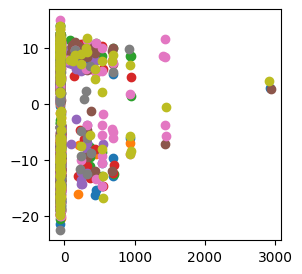

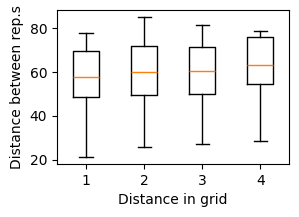

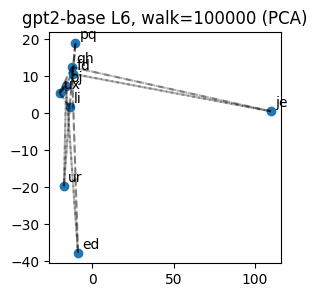

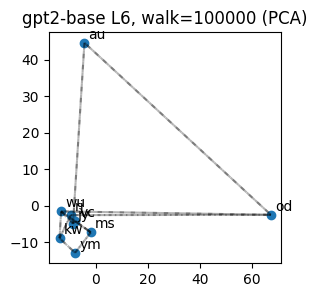

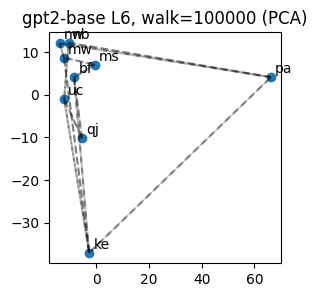

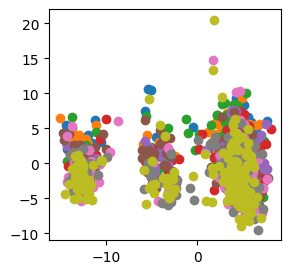

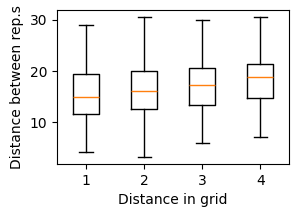

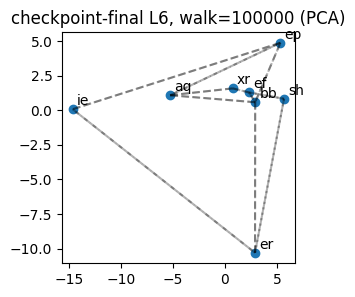

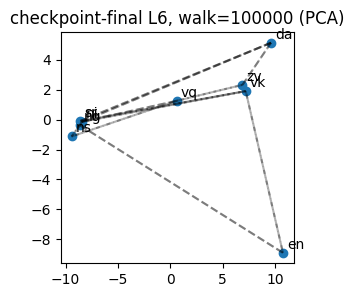

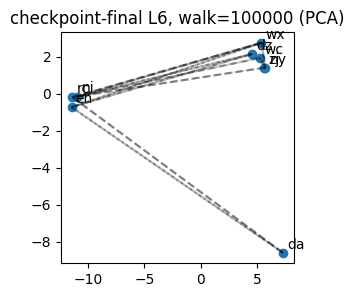

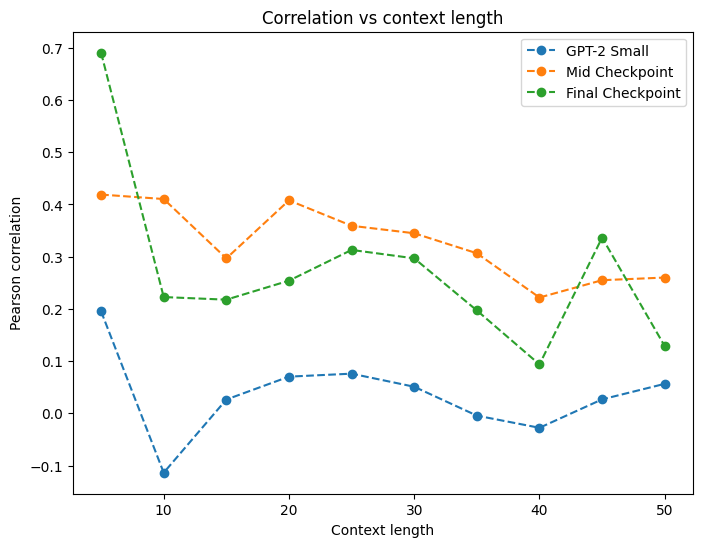

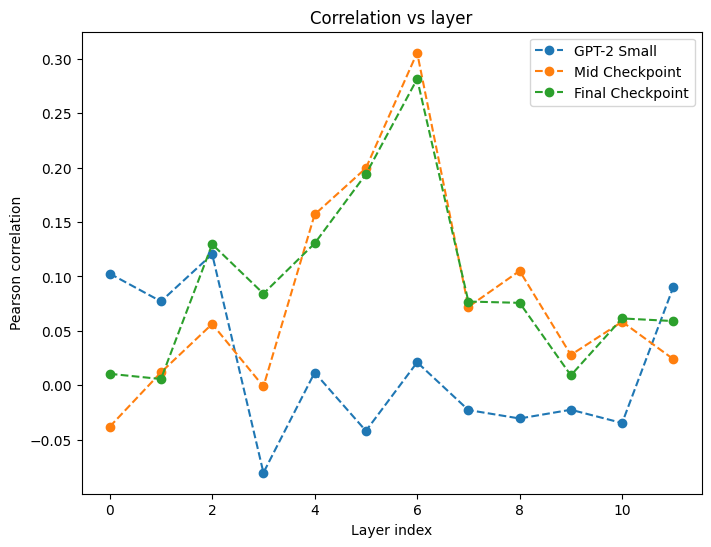

In [20]:


if __name__ == "__main__":

    model_to_test = "checkpoint-final"  # Change this to the model you want to test
    
    multi_graph_allinone(
        model_name="gpt2-base",
        layer_idx=6,
        n_runs=200,
        walk_length=50,
        reducer="pca"
    )

    for i in range(3):
        single_graph_with_edge_lines_and_boxplot(
            layer_idx=6,
            walk_length=100000,
            model_name='gpt2-base',
            reducer="pca"
        )

    multi_graph_allinone(
        model_name=model_to_test,
        layer_idx=6,
        n_runs=200,
        walk_length=50,
        reducer="pca"
    )

    for i in range(3):
        single_graph_with_edge_lines_and_boxplot(
            layer_idx=6,
            walk_length=100000,
            model_name=model_to_test,
            reducer="pca"
        )

    #models_to_compare = ["gpt2-small", model_to_test]
    models_to_compare = ["gpt2-base", "checkpoint-mid", "checkpoint-final"]


    # 1) correlation vs context length, single chart
    correlation_vs_context_length_multi(
        models=models_to_compare,
        layer_idx=6,
        context_lengths=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        n_runs=10,
        rolling_window=1
    )

    # 2) correlation vs layer, single chart
    correlation_vs_layer_multi(
        models=models_to_compare,
        layer_indices=list(range(12)),  
        n_runs=10,
        walk_length=50
    )